In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances as distance
import json

In [2]:
stand_csv = pd.read_csv("stand.csv")
stand_csv["keypoint_coords"] = stand_csv["keypoint_coords"].apply(lambda x : json.loads(x))
stand_csv["keypoint_scores"] = stand_csv["keypoint_scores"].apply(lambda x : json.loads(x))
stand_csv

,Unnamed: 0,keypoint_coords,keypoint_scores
0,0,"[[41.17484540717547, 424.118377831564], [18.37...","[0.9492308497428894, 0.9189706444740295, 0.951..."
1,1,"[[65.42472422400186, 418.31286562686904], [31....","[0.960146427154541, 0.8650374412536621, 0.9544..."
2,2,"[[62.49335976534112, 408.9349744878888], [32.9...","[0.9485349059104919, 0.8589192628860474, 0.948..."
3,3,"[[59.07950964639353, 403.96868692060406], [35....","[0.9301652908325195, 0.8851189613342285, 0.948..."
4,4,"[[57.207370048345524, 397.7698863636364], [33....","[0.9177314043045044, 0.8564090132713318, 0.945..."
...,...,...,...
3921,3921,"[[49.57610093630278, 280.82727087286366], [34....","[0.9961862564086914, 0.9909720420837402, 0.989..."
3922,3922,"[[56.6457626147148, 281.25852477419505], [43.9...","[0.9972397089004517, 0.9906294345855713, 0.987..."
3923,3923,"[[58.755466265556144, 279.0868753817055], [45....","[0.9973528385162354, 0.9927629232406616, 0.990..."
3924,3924,"[[52.921982300587196, 278.26519212443316], [42...","[0.9971316456794739, 0.9915388226509094, 0.989..."


In [3]:
crunch_csv = pd.read_csv("crunch.csv")
crunch_csv["keypoint_coords"] = crunch_csv["keypoint_coords"].apply(lambda x : list(json.loads(x)))
crunch_csv["keypoint_scores"] = crunch_csv["keypoint_scores"].apply(lambda x : list(json.loads(x)))
crunch_csv

,Unnamed: 0,keypoint_coords,keypoint_scores
0,0,"[[179.8922788043355, 626.91329737029], [171.97...","[0.9750418663024902, 0.9369086027145386, 0.767..."
1,1,"[[201.41093785263772, 617.0603745747982], [185...","[0.9682409763336182, 0.9340900182723999, 0.962..."
2,2,"[[215.5135328437007, 609.2460128565154], [198....","[0.9566459655761719, 0.9162812232971191, 0.944..."
3,3,"[[238.0826816558838, 614.4344318882701], [219....","[0.9483922719955444, 0.8992764949798584, 0.933..."
4,4,"[[246.39222340251123, 615.9106883363861], [226...","[0.9549083709716797, 0.9076463580131531, 0.941..."
...,...,...,...
1795,1795,"[[439.6655964740487, 694.0105106043474], [416....","[0.949302613735199, 0.8536398410797119, 0.9496..."
1796,1796,"[[438.34243146763293, 696.7001079942621], [416...","[0.9452518224716187, 0.8464301824569702, 0.947..."
1797,1797,"[[442.92277307288595, 702.4441615930584], [419...","[0.9377988576889038, 0.8237844705581665, 0.945..."
1798,1798,"[[444.2876731739488, 698.6436338287791], [419....","[0.9339144229888916, 0.8247878551483154, 0.939..."


In [4]:
def extract_feature(keypoint_coords):
    features = distance(keypoint_coords[0:1], keypoint_coords[1:])[0]
    # normalize
    mx = max(features)
    mn = min(features)
    for index in range(len(features)):
        features[index] = (features[index] - mn) / (mx-mn)
    return features

# derives features from keypoints
stand_csv["features"] = stand_csv.apply(lambda row: extract_feature(row["keypoint_coords"]), axis=1)
# derives features from keypoints
crunch_csv["features"] = crunch_csv.apply(lambda row: extract_feature(row["keypoint_coords"]), axis=1)


ipykernel_launcher:7: RuntimeWarning: invalid value encountered in double_scalars


In [5]:
# concat 2 df
# append features and label to the numpy
# train_x = np.concatenate(stand_csv["features"], crunch_csv["features"])

# build 2-classes data
ds_x = []
ds_y = []
for _, row in stand_csv.iterrows():
    ds_x.append(list(row["features"]))
    ds_y.append(0)
for _, row in crunch_csv.iterrows():
    ds_x.append(list(row["features"]))
    ds_y.append(1)

In [6]:
# Remove NaN rows
# NaN happens when very distances are zeroes, just because of normalization
from sklearn.model_selection import train_test_split
ds_x = np.array(ds_x)
ds_y = np.array(ds_y)

selected_non_nan = ~np.isnan(ds_x).any(axis=1)
ds_x = ds_x[selected_non_nan]
ds_y = ds_y[selected_non_nan]

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc, roc_auc_score

s_acc = s_loss = s_auc = 0
def scorer(model, X_test, y_test):
    global s_acc, s_auc, s_loss
    y_pred = model.predict(X_test)
    s_acc += accuracy_score(y_test, y_pred)

    # fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=2)
    # s_auc += auc(fpr, tpr)

    y_pred = model.predict_proba(X_test)
    s_loss += log_loss(y_test, y_pred)
    s_auc += roc_auc_score(y_test, y_pred[:, 1])
    return s_acc

def score_dataset(dataset_name, model, X, y, cv=None):
    global s_acc, s_auc, s_loss
    if cv:
        s_acc = s_auc = s_loss = 0
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        mean_acc = s_acc/cv
        mean_auc = s_auc/cv
        mean_loss = s_loss/cv
        print("%12s %2d-folds = %.4f; auc = %.4f with loss = %.4f" % (dataset_name, cv, mean_acc, mean_auc, mean_loss))
        return mean_acc, mean_auc, mean_loss
    else:
        for nFold in range(2, 10+1):
            scores = cross_val_score(model, X, y, cv=nFold)
            print("%s %2d-folds = %.3f" % (dataset_name, nFold, np.mean(scores)))

In [8]:
import pandas as pd
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'kNN': KNeighborsClassifier(n_neighbors=2),
    'GaussianNB': GaussianNB(),
    'DecisionTree': tree.DecisionTreeClassifier(criterion="gini"),
    'Bagging': BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=100),
    'AdamBoost': AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=2), n_estimators=100),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'SVM_Linear': svm.SVC(kernel='linear', C=1000, probability=True),
    'SVM_Poly': svm.SVC(kernel='poly', C=1000, probability=True),
    'SVM_RBF': svm.SVC(kernel='rbf', C=1000, gamma=0.01, probability=True),
    'SVM_Sigmoid': svm.SVC(kernel='sigmoid', C=1000, gamma=0.0001, probability=True)
}

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "AUC", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for model in models.items():
    mean_acc, mean_auc, mean_loss = score_dataset(model[0], model[1], ds_x, ds_y, cv=10)
    log_entry = pd.DataFrame([[model[0], mean_acc*100, mean_auc*100, mean_loss]], columns=log_cols)
    log = log.append(log_entry)

         kNN 10-folds = 0.9797; auc = 0.9818 with loss = 0.4814
  GaussianNB 10-folds = 0.9754; auc = 0.9957 with loss = 0.2037
DecisionTree 10-folds = 0.9687; auc = 0.9635 with loss = 1.0794
     Bagging 10-folds = 0.9780; auc = 0.9963 with loss = 0.1247
   AdamBoost 10-folds = 0.9848; auc = 0.9981 with loss = 0.3109
RandomForest 10-folds = 0.9869; auc = 0.9996 with loss = 0.0464
  SVM_Linear 10-folds = 0.9731; auc = 0.9883 with loss = 0.1538
    SVM_Poly 10-folds = 0.9815; auc = 0.9941 with loss = 0.1912
     SVM_RBF 10-folds = 0.9719; auc = 0.9880 with loss = 0.1542
 SVM_Sigmoid 10-folds = 0.9607; auc = 0.9764 with loss = 0.1640


In [9]:
print(log)
log.to_csv('log.csv', index=False)

     Classifier   Accuracy        AUC  Log Loss
0           kNN  97.974774  98.180092  0.481351
0    GaussianNB  97.538047  99.572064  0.203683
0  DecisionTree  96.874718  96.351814  1.079434
0       Bagging  97.800254  99.630500  0.124745
0     AdamBoost  98.480913  99.807128  0.310929
0  RandomForest  98.690672  99.962985  0.046444
0    SVM_Linear  97.310957  98.825377  0.153809
0      SVM_Poly  98.148897  99.409091  0.191181
0       SVM_RBF  97.188854  98.797413  0.154225
0   SVM_Sigmoid  96.071651  97.641142  0.164016


Text(0.5, 1.0, 'Classifier Log Loss')

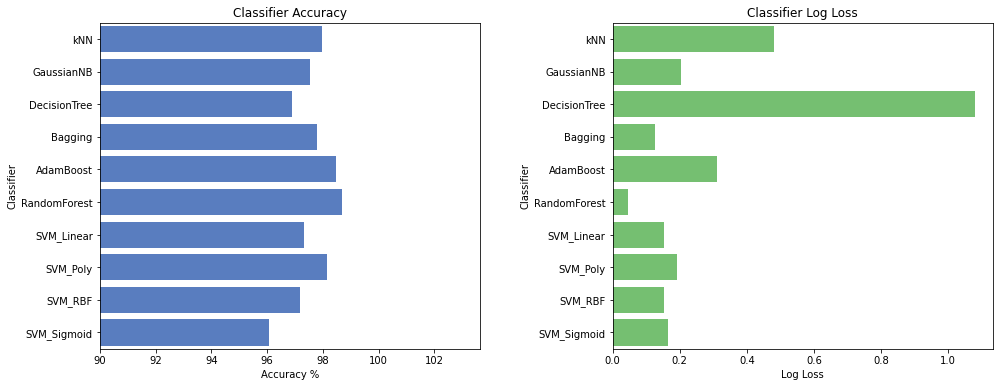

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplots_adjust(wspace=0.35)

# Plot Accuracy Figure
plt.subplot(1, 2, 1)
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')

# Plot Log Loss Figure
plt.xlim(left=90)
plt.subplot(1, 2, 2)
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")
plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')

In [ ]:
from sklearn.model_selection import train_test_split

# Sử dụng nghi thức Hold-out
model = RandomForestClassifier(n_estimators=100)
model.fit(ds_x, ds_y)

# output model
import pickle
file_name = 'stand_crunch.model'
with open(file_name, 'wb') as f:
    pickle.dump(model, f)
# Export model
# dump(model, 'diabetes.model')